## Import statements

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import wave
import contextlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models
from tensorflow.keras import layers

%matplotlib inline

## Extract data from titles

### Get file names

In [2]:
# Use relative file path to get directory of files"
path = "../raw_data/1-24 Audio Song and speech"

# Use os library to get file_names
directories = os.listdir(path)

### Process each filename to create arrays with important elements

In [3]:
# Initialize empty arrays for each field
speech_song = []
emotion = []
intensity = []
statement = []
repetitions = []
actor_id = []
gender = []

# Use for loop to process each file name.
for file in directories:
    f = file[0:-4]
    f = f.split("-")
    speech_song.append(f[1])
    emotion.append(f[2])
    intensity.append(f[3])
    statement.append(f[4])
    repetitions.append(f[5])
    actor_id.append(f[6])
    gender.append(int(f[6]) % 2)

### Create a dataframe with the array of elements

In [4]:
# Create the empty data frame.
df = pd.DataFrame()

# Create the columns in the dataframe using arrays
df["speech_song"] = speech_song
df["emotion"] = emotion
df["intensity"] = intensity
df["statement"] = statement
df["repetitions"] = repetitions
df["actor_id"] = actor_id
df["gender"] = gender

### Create string version of columns and dummy variables for emotions

In [5]:
# Create a gender in string version
df["gender_s"] = df["gender"].apply(lambda x: "Male" if x == 1 else "Female")


# Create an emotion dict to map the emotions
emotion_dict = {"01":"Neutral", "02":"Calm", "03":"Happy", "04":"Sad", "05":"Angry", "06":"Fearful"}

#Create a string column of the emotions and map them to emotion_dict
df["emotion_s"] = df["emotion"].map(emotion_dict)

# Get a dummies df of the emotions_strings
dummies = pd.get_dummies(df["emotion_s"])

# Horizontally concat the dummies df with original df.
df = pd.concat([df, dummies], axis=1)

df

,speech_song,emotion,intensity,statement,repetitions,actor_id,gender,gender_s,emotion_s,Angry,Calm,Fearful,Happy,Neutral,Sad
0,01,03,02,01,01,23,1,Male,Happy,0,0,0,1,0,0
1,01,04,02,02,02,15,1,Male,Sad,0,0,0,0,0,1
2,01,05,02,02,01,19,1,Male,Angry,1,0,0,0,0,0
3,01,03,02,01,02,07,1,Male,Happy,0,0,0,1,0,0
4,01,01,01,02,02,22,0,Female,Neutral,0,0,0,0,1,0
5,01,05,02,02,01,24,0,Female,Angry,1,0,0,0,0,0
6,01,03,02,02,02,18,0,Female,Happy,0,0,0,1,0,0
7,01,03,01,02,01,20,0,Female,Happy,0,0,0,1,0,0
8,02,01,01,02,01,24,0,Female,Neutral,0,0,0,0,1,0
9,02,06,02,02,01,19,1,Male,Fearful,0,0,1,0,0,0


In [6]:
df["Calm"].sum()

376

## Getting spectograms from the signals

### Use librosa to create an array of signals

In [7]:
# Make an empty array with signals.
signals = []
counter = 0
# Use for loop to load every signal and append into array.
for file in directories:
    print(counter)
    with contextlib.closing(wave.open(path + "/" + file,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        sampling_rate = 80000/duration
        loaded_file, _ = librosa.load(path + "/" + file, sr = sampling_rate) # Use a duration of 2.9 so that the signals are all the same size
        signals.append(loaded_file)
    counter += 1



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


### Cut the last frame from frames greater than 80000

In [8]:
standardized_signals = []

for signal in signals:
    st_signal = signal[0:80000]
    standardized_signals.append(st_signal)
    

### Make sure that all the shapes are the same

In [9]:
# Create an empty array to store first dimenstion of shapes.
shapes1 = []


# Use for loop to append dimension to array.
for signal in standardized_signals:
    shapes1.append(signal.shape[0])
    

# Transform the arrays into np.arrays    
shapes1 = np.array(shapes1)

# Print out the unique values of each array.
np.unique(shapes1)

unique, frequency = np.unique(shapes1,  
                              return_counts = True) 

print(unique)
print(frequency)

[80000]
[2068]


### Define variables for spectograms

In [10]:
# Define a frame size
FRAME_SIZE = 2048

# Define a hop size.
HOP_SIZE = 512

# Define the default sampling rate of librosa
sr = 22050

### Create a function that will create spectograms

In [11]:
def create_spectogram(signal, frame_size, hop_lngth):
    """Define a function that given a signal will create a logarithmic spectogram in decibels."""
    
    # Create a complex spectogram with short time fourier transform
    complex_spectogram = librosa.stft(signal, n_fft = frame_size, hop_length= hop_lngth)
    
    # Get only the magnitudes of the complex spectogram
    spectogram = np.abs(complex_spectogram)**2
    
    # Scale the spectogram into decibes (logarithmic)
    log_spectogram = librosa.power_to_db(spectogram)
    
    # Return the logarithmic spectogram.
    return log_spectogram

### Create function that plots spectograms

In [12]:
def plot_spectogram(Y, sr, hop_length, y_axis= "linear"):
    """Function that plots a spectogram with linear default y_axis"""
    
    # Define the figure size
    plt.figure(figsize=(25,10))
    #Use librosa library to plot spectogram.
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length= hop_length,
                             x_axis="time",
                             y_axis=y_axis
                            )
    # Adda a colorbar to the plot
    plt.colorbar(format="%+2.f")

### Create an array of log spectograms using the create_spectogram function

In [13]:
# Create empty array to store log spectograms
spectograms = []

# Use for loop to create spectograms and append them to the spectograms array
for signal in signals:
    spectogram = create_spectogram(signal, FRAME_SIZE, HOP_SIZE)
    spectograms.append(spectogram)

### Make sure that the spectograms have the same shapes

In [14]:
# Create an empty array to store first dimenstion of shapes.
shapes1 = []
shapes2 = []


# Use for loop to append dimension to array.
for spectogram in spectograms:
    shapes1.append(spectogram.shape[0])
    shapes2.append(spectogram.shape[1])
    
# Transform the arrays into np.arrays    
shapes1 = np.array(shapes1)
shapes2 = np.array(shapes2)

# Print out the unique values of each array.
print(np.unique(shapes1))
print(np.unique(shapes2))

[1025]
[157]


### Plot first spectogram as an example

/home/jcbanos/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jcbanos/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jcbanos/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


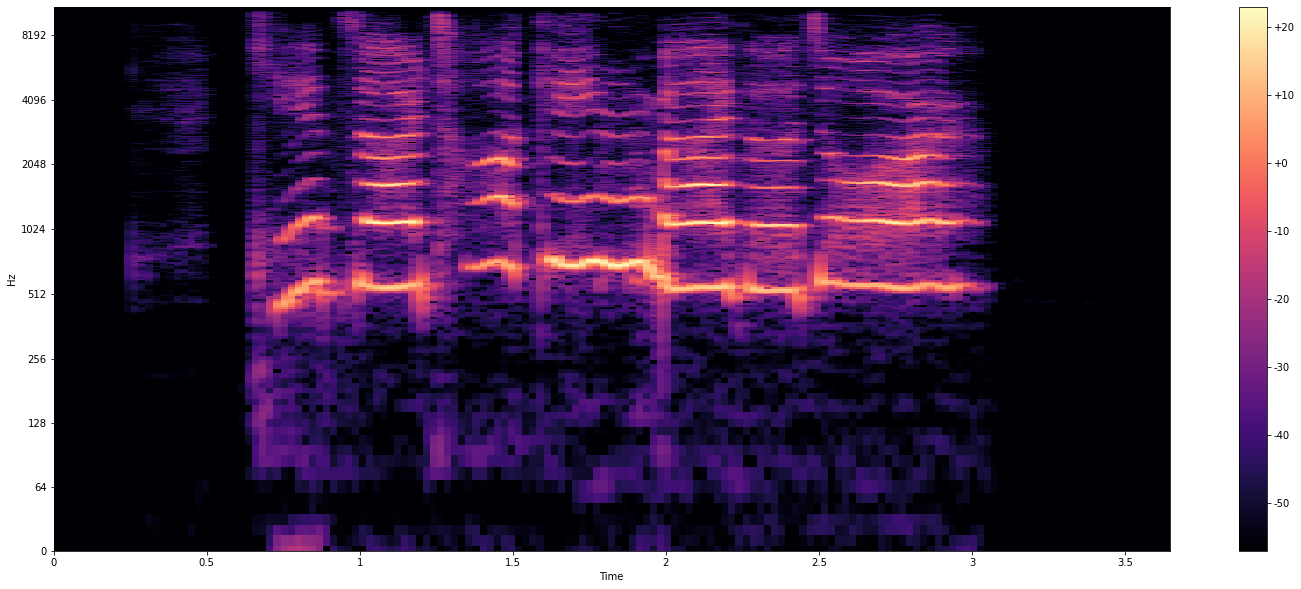

In [15]:
plot_spectogram(spectograms[100], sr, HOP_SIZE, y_axis="log")

## Getting mel-spectograms from the signals

### Create function to extract mel spectograms

In [16]:
def create_mel_spectogram(signal, sr, n_fft, hop_size, n_mels):
    """Function that creates a log mel spectogram"""
    
    # Get vanilla mel spectogram
    mel_spectogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft= n_fft, hop_length= hop_size, n_mels= n_mels)
    
    # Transform vanilla mel spectogram into log spectogram.
    log_mel_spectogram = librosa.power_to_db(mel_spectogram)
    
    return log_mel_spectogram

### Create function to plot mel spectograms

In [17]:
def plot_mel_spectogram(Y, sr, hop_length):
    """Function that plots a spectogram"""
    
    # Define the figure size
    plt.figure(figsize=(25,10))
    #Use librosa library to plot mel_spectogram.
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length= hop_length,
                             x_axis="time",
                             y_axis="mel"
                            )
    # Adda a colorbar to the plot
    plt.colorbar(format="%+2.f")

### Create mel spectograms from each signal

In [18]:
# Create empty array to store log mel_spectograms
mel_spectograms = []

# Use for loop to create log mel_spectograms and append them to the spectograms array
for signal in signals:
    mel_spectogram = create_mel_spectogram(signal, sr, FRAME_SIZE, HOP_SIZE, 40)
    mel_spectograms.append(mel_spectogram)

### Make sure that the mel spectograms have the same shape.

In [19]:
# Create an empty array to store first dimenstion of shapes.
shapes1 = []
shapes2 = []


# Use for loop to append dimension to array.
for mel_spectogram in mel_spectograms:
    shapes1.append(mel_spectogram.shape[0])
    shapes2.append(mel_spectogram.shape[1])
    
# Transform the arrays into np.arrays    
shapes1 = np.array(shapes1)
shapes2 = np.array(shapes2)

# Print out the unique values of each array.
print(np.unique(shapes1))
print(np.unique(shapes2))

[40]
[157]


### Plot first mel_spectogram as example

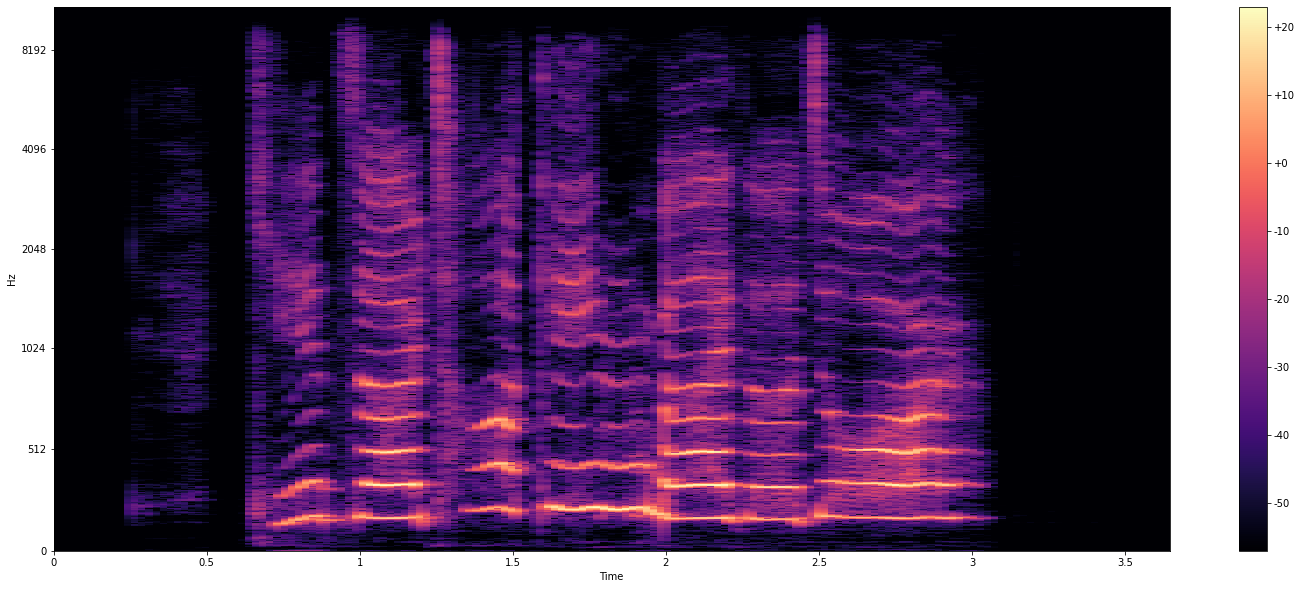

In [20]:
plot_mel_spectogram(spectograms[100], sr, HOP_SIZE)

## MFCC extraction

### Create function to extract MFCCs

In [21]:
def create_MFCCS(signal, n_mfccs, sr):
    """Define function to create MFCCS"""
    
    #Use librosa library to generate MFCCS
    mfccs = librosa.feature.mfcc(signal, n_mfcc= n_mfccs, sr=sr)
    return mfccs

### Create function to plot MFCCS

In [22]:
def plot_MFCCS(mfccs, sr):
    
    # Set figure size for plot
    plt.figure(figsize=(25, 10))
    
    # Use librosa library to plot MFCC
    librosa.display.specshow(mfccs,
                            x_axis="time",
                            sr=sr)
    
    # Add a colorbar
    plt.colorbar(format="%+2f")

### Get MFCCS from signals

In [23]:
# Create empty array to store MFCCs
mfccs = []

# Use for loop to create MFCCs and append them to the mfccs array
for signal in standardized_signals:
    mfcc = create_MFCCS(signal, 13, sr)
    mfccs.append(mfcc)

### Plot first MFCC as example

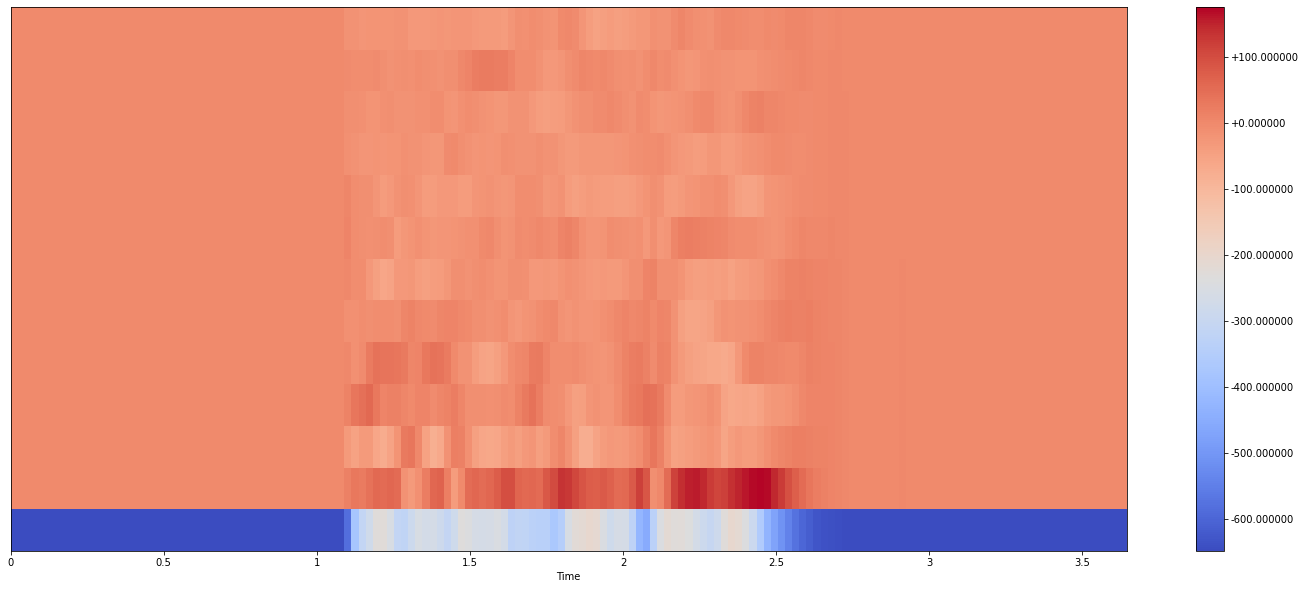

In [24]:
plot_MFCCS(mfccs[0], sr)

### Create function to get first order derivative of MFCCS

In [25]:
def delta_MFCCS(mfccs):
    """Function that gets the first order derivative of MFCCS"""
    return librosa.feature.delta(mfccs)

### Create function to get second order derivative of MFCCS

In [26]:
def delta2_MFCCS(delta_mfccs):
    """Function that returns the second order derivative of MFCCS"""
    return librosa.feature.delta(delta_mfccs, order=2)

### Create function that creates a compregensive MFCCS

In [27]:
def create_comprehensive_MFCCS(signal, n_mfccs, sr):
    """Function that returns MFCCS numpy array with first and second order derivative."""
    mfccs = create_MFCCS(signal, n_mfccs, sr)
    delta_mfccs= delta_MFCCS(mfccs)
    delta2_mfccs = delta2_MFCCS(delta_mfccs)
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfccs

### Get comprehensive MFCCS from signals

In [28]:
# Create empty array to store comprehensive MFCCs
comprehensive_mfccs = []

# Use for loop to create comprehensive MFCCs and append them to the comprehensive_mfccs array
for signal in standardized_signals:
    comprehensive_mfcc = create_comprehensive_MFCCS(signal, 13, sr)
    comprehensive_mfccs.append(comprehensive_mfcc)

In [29]:
np.array(comprehensive_mfccs).shape

(2068, 39, 157)

## Play with neural networks

In [30]:
# Create empty array to store log mel_spectograms
mel_spectograms = []

# Use for loop to create log mel_spectograms and append them to the spectograms array
for signal in standardized_signals:
    mel_spectogram = create_mel_spectogram(signal, sr, FRAME_SIZE, HOP_SIZE, 90)
    mel_spectograms.append(mel_spectogram)

In [31]:
comprehensive_mfccs = []

# Use for loop to create comprehensive MFCCs and append them to the comprehensive_mfccs array
for signal in standardized_signals:
    comprehensive_mfcc = create_comprehensive_MFCCS(signal, 13, sr)
    comprehensive_mfccs.append(comprehensive_mfcc)

In [32]:
mfccs = []

# Use for loop to create MFCCs and append them to the mfccs array
for signal in standardized_signals:
    mfcc = create_MFCCS(signal, 13, sr)
    mfccs.append(mfcc)

In [33]:
chromas = []
for signal in standardized_signals:
    chroma = librosa.feature.chroma_stft(signal, sr)
    chromas.append(chroma)


In [34]:
chromas = np.array(chromas)
chromas.shape

(2068, 12, 157)

In [35]:
mel_spectograms = np.array(mel_spectograms)
mel_spectograms.shape

(2068, 90, 157)

In [36]:
comprehensive_mfccs = np.array(comprehensive_mfccs)
comprehensive_mfccs.shape

(2068, 39, 157)

In [37]:
mfccs = np.array(mfccs)

In [38]:
full_features = np.hstack((mel_spectograms, comprehensive_mfccs, chromas))

In [39]:
X = full_features

In [40]:
y= df[["Angry", "Calm", "Fearful", "Happy", "Neutral", "Sad"]]
y.shape

(2068, 6)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state = 42)

In [42]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [43]:
X_train.shape

(1861, 141, 157)

In [44]:
X_train = X_train.reshape((1861, 141, 157, 1))

In [45]:
def initialize_model():
    # YOUR CODE HERE
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(141, 157, 1), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(6, activation='softmax')) 
    return model

In [46]:
model = initialize_model()

In [47]:
def compile_model(model):
    # YOUR CODE HERE
    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [48]:
compile_model(model)

es = EarlyStopping(patience=15, restore_best_weights= True)

history = model.fit(X_train, y_train,
              batch_size=32,
              epochs=100,
              validation_split=0.2,
              callbacks=[es])

Epoch 1/100
47/47 [==============================] - 47s 1000ms/step - loss: 2.1938 - accuracy: 0.1774 - val_loss: 1.7721 - val_accuracy: 0.2627
Epoch 2/100
47/47 [==============================] - 47s 994ms/step - loss: 1.7194 - accuracy: 0.2628 - val_loss: 1.6110 - val_accuracy: 0.3351
Epoch 3/100
47/47 [==============================] - 47s 1s/step - loss: 1.4847 - accuracy: 0.3313 - val_loss: 1.5449 - val_accuracy: 0.3968
Epoch 4/100
47/47 [==============================] - 47s 994ms/step - loss: 1.4468 - accuracy: 0.3649 - val_loss: 1.6174 - val_accuracy: 0.3405
Epoch 5/100
47/47 [==============================] - 47s 1s/step - loss: 1.3587 - accuracy: 0.3918 - val_loss: 1.3178 - val_accuracy: 0.4129
Epoch 6/100
47/47 [==============================] - 48s 1s/step - loss: 1.2725 - accuracy: 0.4247 - val_loss: 1.3409 - val_accuracy: 0.4263
Epoch 7/100
47/47 [==============================] - 48s 1s/step - loss: 1.2831 - accuracy: 0.4147 - val_loss: 1.2356 - val_accuracy: 0.4638
Epo

In [54]:
# results = model.evaluate(X_test, y_test, verbose=0)
X_test.shape


(207, 161, 176)

In [147]:
models.save_model(model, 'jcbanos_67')


INFO:tensorflow:Assets written to: jcbanos_67/assets


In [148]:
model = models.load_model('jcbanos_67')

In [150]:
model.predict(X_train[0].reshape(1, 141, 157, 1))

array([[0.00791049, 0.00766406, 0.2878975 , 0.17461932, 0.0760658 ,
        0.44584274]], dtype=float32)

## Second Data Set

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import wave
import contextlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models
from tensorflow.keras import layers




%matplotlib inline

In [4]:
# Define a frame size
FRAME_SIZE = 2048

# Define a hop size.
HOP_SIZE = 512

# Define the default sampling rate of librosa
sr = 22050

In [2]:
def create_mel_spectogram(signal, sr, n_fft, hop_size, n_mels):
    """Function that creates a log mel spectogram"""
    
    # Get vanilla mel spectogram
    mel_spectogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft= n_fft, hop_length= hop_size, n_mels= n_mels)
    
    # Transform vanilla mel spectogram into log spectogram.
    log_mel_spectogram = librosa.power_to_db(mel_spectogram)
    
    return log_mel_spectogram

In [3]:
def create_MFCCS(signal, n_mfccs, sr):
    """Define function to create MFCCS"""
    
    #Use librosa library to generate MFCCS
    mfccs = librosa.feature.mfcc(signal, n_mfcc= n_mfccs, sr=sr)
    return mfccs

In [6]:
def delta_MFCCS(mfccs):
    """Function that gets the first order derivative of MFCCS"""
    return librosa.feature.delta(mfccs)

In [7]:
def delta2_MFCCS(delta_mfccs):
    """Function that returns the second order derivative of MFCCS"""
    return librosa.feature.delta(delta_mfccs, order=2)

In [10]:
def create_comprehensive_MFCCS(signal, n_mfccs, sr):
    """Function that returns MFCCS numpy array with first and second order derivative."""
    mfccs = create_MFCCS(signal, n_mfccs, sr)
    delta_mfccs= delta_MFCCS(mfccs)
    delta2_mfccs = delta2_MFCCS(delta_mfccs)
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfccs

In [11]:
path_crem = "../raw_data/AudioWAV"

# Use os library to get file_names
directories = os.listdir(path_crem)

In [12]:
directories

['1017_TAI_FEA_XX.wav',
 '1063_ITH_NEU_XX.wav',
 '1017_IEO_FEA_MD.wav',
 '1018_IEO_SAD_MD.wav',
 '1010_TIE_SAD_XX.wav',
 '1063_IOM_FEA_XX.wav',
 '1032_IWW_HAP_XX.wav',
 '1011_ITH_SAD_XX.wav',
 '1066_WSI_FEA_XX.wav',
 '1004_TSI_FEA_XX.wav',
 '1036_WSI_HAP_XX.wav',
 '1044_IEO_DIS_HI.wav',
 '1048_ITH_FEA_XX.wav',
 '1038_ITH_SAD_XX.wav',
 '1056_IEO_ANG_HI.wav',
 '1019_IOM_FEA_XX.wav',
 '1010_TIE_NEU_XX.wav',
 '1016_TSI_FEA_XX.wav',
 '1020_IEO_SAD_LO.wav',
 '1030_IEO_SAD_MD.wav',
 '1073_IEO_SAD_LO.wav',
 '1055_IWW_FEA_XX.wav',
 '1079_IOM_ANG_XX.wav',
 '1026_TSI_FEA_XX.wav',
 '1087_IEO_FEA_MD.wav',
 '1082_IEO_ANG_LO.wav',
 '1011_TSI_ANG_XX.wav',
 '1087_IOM_NEU_XX.wav',
 '1015_WSI_ANG_XX.wav',
 '1014_IEO_FEA_HI.wav',
 '1047_ITS_NEU_XX.wav',
 '1036_IEO_HAP_LO.wav',
 '1023_ITS_NEU_XX.wav',
 '1069_ITS_ANG_XX.wav',
 '1038_IOM_NEU_XX.wav',
 '1077_IEO_DIS_LO.wav',
 '1013_IEO_ANG_MD.wav',
 '1076_IEO_HAP_LO.wav',
 '1079_MTI_ANG_XX.wav',
 '1081_ITH_FEA_XX.wav',
 '1074_IEO_HAP_MD.wav',
 '1021_ITS_ANG_X

In [13]:
files_crem = [ fi for fi in directories if fi.split("_")[2] != "DIS" ]

In [14]:
files_crem

['1017_TAI_FEA_XX.wav',
 '1063_ITH_NEU_XX.wav',
 '1017_IEO_FEA_MD.wav',
 '1018_IEO_SAD_MD.wav',
 '1010_TIE_SAD_XX.wav',
 '1063_IOM_FEA_XX.wav',
 '1032_IWW_HAP_XX.wav',
 '1011_ITH_SAD_XX.wav',
 '1066_WSI_FEA_XX.wav',
 '1004_TSI_FEA_XX.wav',
 '1036_WSI_HAP_XX.wav',
 '1048_ITH_FEA_XX.wav',
 '1038_ITH_SAD_XX.wav',
 '1056_IEO_ANG_HI.wav',
 '1019_IOM_FEA_XX.wav',
 '1010_TIE_NEU_XX.wav',
 '1016_TSI_FEA_XX.wav',
 '1020_IEO_SAD_LO.wav',
 '1030_IEO_SAD_MD.wav',
 '1073_IEO_SAD_LO.wav',
 '1055_IWW_FEA_XX.wav',
 '1079_IOM_ANG_XX.wav',
 '1026_TSI_FEA_XX.wav',
 '1087_IEO_FEA_MD.wav',
 '1082_IEO_ANG_LO.wav',
 '1011_TSI_ANG_XX.wav',
 '1087_IOM_NEU_XX.wav',
 '1015_WSI_ANG_XX.wav',
 '1014_IEO_FEA_HI.wav',
 '1047_ITS_NEU_XX.wav',
 '1036_IEO_HAP_LO.wav',
 '1023_ITS_NEU_XX.wav',
 '1069_ITS_ANG_XX.wav',
 '1038_IOM_NEU_XX.wav',
 '1013_IEO_ANG_MD.wav',
 '1076_IEO_HAP_LO.wav',
 '1079_MTI_ANG_XX.wav',
 '1081_ITH_FEA_XX.wav',
 '1074_IEO_HAP_MD.wav',
 '1021_ITS_ANG_XX.wav',
 '1067_WSI_SAD_XX.wav',
 '1014_TSI_FEA_X

In [15]:
emotion = []

for file in files_crem:
    f = file[0:-4]
    f = f.split("_")
    emotion.append(f[2])

In [16]:
df2 = pd.DataFrame()
df2["emotion"] = emotion

df2.head()

emotion_dict = {"NEU":"Neutral", "HAP":"Happy", "SAD":"Sad", "ANG":"Angry", "FEA":"Fearful"}

df2["emotion_s"] = df2["emotion"].map(emotion_dict)
dummies = pd.get_dummies(df2["emotion_s"])
df2 = pd.concat([df2, dummies], axis=1)

df2.head()

,emotion,emotion_s,Angry,Fearful,Happy,Neutral,Sad
0,FEA,Fearful,0,1,0,0,0
1,NEU,Neutral,0,0,0,1,0
2,FEA,Fearful,0,1,0,0,0
3,SAD,Sad,0,0,0,0,1
4,SAD,Sad,0,0,0,0,1


In [17]:
path_rav = "../raw_data/1-24 Audio Song and speech"

# Use os library to get file_names
directories = os.listdir(path_rav)
files_rav = [ fi for fi in directories if fi.split("-")[2] != "02" ]


In [18]:
files_rav

['03-01-03-02-01-01-23.wav',
 '03-01-04-02-02-02-15.wav',
 '03-01-05-02-02-01-19.wav',
 '03-01-03-02-01-02-07.wav',
 '03-01-01-01-02-02-22.wav',
 '03-01-05-02-02-01-24.wav',
 '03-01-03-02-02-02-18.wav',
 '03-01-03-01-02-01-20.wav',
 '03-02-01-01-02-01-24.wav',
 '03-02-06-02-02-01-19.wav',
 '03-01-06-02-02-01-11.wav',
 '03-01-01-01-01-01-02.wav',
 '03-01-05-02-02-02-09.wav',
 '03-02-05-01-02-02-04.wav',
 '03-01-04-02-02-01-22.wav',
 '03-02-01-01-02-02-16.wav',
 '03-02-05-02-01-02-22.wav',
 '03-02-01-01-01-02-23.wav',
 '03-02-03-01-02-01-08.wav',
 '03-02-06-01-01-01-17.wav',
 '03-01-06-02-01-01-10.wav',
 '03-02-06-01-01-01-23.wav',
 '03-01-06-01-02-02-19.wav',
 '03-02-04-01-01-01-24.wav',
 '03-02-04-02-02-02-22.wav',
 '03-01-04-02-01-01-22.wav',
 '03-01-04-02-02-01-13.wav',
 '03-02-06-02-02-01-04.wav',
 '03-01-03-01-02-01-18.wav',
 '03-02-04-01-01-01-01.wav',
 '03-01-04-01-02-01-01.wav',
 '03-01-01-01-02-01-12.wav',
 '03-01-01-01-01-02-19.wav',
 '03-02-01-01-02-01-20.wav',
 '03-02-01-01-

In [19]:
# Initialize empty arrays for each field
speech_song = []
emotion = []
intensity = []
statement = []
repetitions = []
actor_id = []
gender = []

for file in files_rav:
    f = file[0:-4]
    f = f.split("-")
    speech_song.append(f[1])
    emotion.append(f[2])
    intensity.append(f[3])
    statement.append(f[4])
    repetitions.append(f[5])
    actor_id.append(f[6])
    gender.append(int(f[6]) % 2)

In [20]:
# Create the empty data frame.
df = pd.DataFrame()

# Create the columns in the dataframe using arrays
df["speech_song"] = speech_song
df["emotion"] = emotion
df["intensity"] = intensity
df["statement"] = statement
df["repetitions"] = repetitions
df["actor_id"] = actor_id
df["gender"] = gender

In [21]:
# Create a gender in string version
df["gender_s"] = df["gender"].apply(lambda x: "Male" if x == 1 else "Female")


# Create an emotion dict to map the emotions
emotion_dict = {"01":"Neutral", "02":"Calm", "03":"Happy", "04":"Sad", "05":"Angry", "06":"Fearful"}

#Create a string column of the emotions and map them to emotion_dict
df["emotion_s"] = df["emotion"].map(emotion_dict)

# Get a dummies df of the emotions_strings
dummies = pd.get_dummies(df["emotion_s"])

# Horizontally concat the dummies df with original df.
df = pd.concat([df, dummies], axis=1)

df

,speech_song,emotion,intensity,statement,repetitions,actor_id,gender,gender_s,emotion_s,Angry,Fearful,Happy,Neutral,Sad
0,01,03,02,01,01,23,1,Male,Happy,0,0,1,0,0
1,01,04,02,02,02,15,1,Male,Sad,0,0,0,0,1
2,01,05,02,02,01,19,1,Male,Angry,1,0,0,0,0
3,01,03,02,01,02,07,1,Male,Happy,0,0,1,0,0
4,01,01,01,02,02,22,0,Female,Neutral,0,0,0,1,0
5,01,05,02,02,01,24,0,Female,Angry,1,0,0,0,0
6,01,03,02,02,02,18,0,Female,Happy,0,0,1,0,0
7,01,03,01,02,01,20,0,Female,Happy,0,0,1,0,0
8,02,01,01,02,01,24,0,Female,Neutral,0,0,0,1,0
9,02,06,02,02,01,19,1,Male,Fearful,0,1,0,0,0


In [22]:
y= df[["Angry", "Fearful", "Happy", "Neutral", "Sad"]]

y = pd.concat((y, df2[["Angry", "Fearful", "Happy", "Neutral", "Sad"]]), axis = 0)

y

,Angry,Fearful,Happy,Neutral,Sad
0,0,0,1,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0
5,1,0,0,0,0
6,0,0,1,0,0
7,0,0,1,0,0
8,0,0,0,1,0
9,0,1,0,0,0


In [ ]:
# Make an empty array with signals.
signals_crem = []
counter = 0
# Use for loop to load every signal and append into array.
for file in files_crem:
    print(counter)
    with contextlib.closing(wave.open(path_crem + "/" + file,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        sampling_rate = 90000/duration
        loaded_file, _ = librosa.load(path_crem + "/" + file, sr = sampling_rate) # Use a duration of 2.9 so that the signals are all the same size
        signals_crem.append(loaded_file)
    counter += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [ ]:
standardized_signals_crem = []

for signal in signals_crem:
    st_signal = signal[0:90000]
    standardized_signals_crem.append(st_signal)
    

In [ ]:
# Make an empty array with signals.
signals_rav = []
counter = 0
# Use for loop to load every signal and append into array.
for file in files_rav:
    print(counter)
    with contextlib.closing(wave.open(path_rav + "/" + file,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        sampling_rate = 90000/duration
        loaded_file, _ = librosa.load(path_rav + "/" + file, sr = sampling_rate) # Use a duration of 2.9 so that the signals are all the same size
        signals_rav.append(loaded_file)
    counter += 1

In [25]:
standardized_signals_rav = []

for signal in signals_rav:
    st_signal = signal[0:90000]
    standardized_signals_rav.append(st_signal)
    

In [26]:
# Create empty array to store log mel_spectograms
mel_spectograms_crem = []

# Use for loop to create log mel_spectograms and append them to the spectograms array
for signal in standardized_signals_crem:
    mel_spectogram = create_mel_spectogram(signal, sr, FRAME_SIZE, HOP_SIZE, 110)
    mel_spectograms_crem.append(mel_spectogram)

In [27]:
comprehensive_mfccs_crem = []

# Use for loop to create comprehensive MFCCs and append them to the comprehensive_mfccs array
for signal in standardized_signals_crem:
    comprehensive_mfcc = create_comprehensive_MFCCS(signal, 13, sr)
    comprehensive_mfccs_crem.append(comprehensive_mfcc)

In [28]:
chromas_crem = []
for signal in standardized_signals_crem:
    chroma = librosa.feature.chroma_stft(signal, sr)
    chromas_crem.append(chroma)


/home/jcbanos/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [29]:
mel_spectograms_crem = np.array(mel_spectograms_crem)
comprehensive_mfccs_crem = np.array(comprehensive_mfccs_crem)
chromas_crem = np.array(chromas_crem)


In [30]:
mel_spectograms_crem.shape

(6171, 110, 176)

In [31]:
comprehensive_mfccs_crem.shape

(6171, 39, 176)

In [32]:
chromas_crem.shape

(6171, 12, 176)

In [33]:
full_features_crem = np.hstack((mel_spectograms_crem, comprehensive_mfccs_crem, chromas_crem))

In [34]:
full_features_crem.shape

(6171, 161, 176)

In [35]:
# Create empty array to store log mel_spectograms
mel_spectograms_rav = []

# Use for loop to create log mel_spectograms and append them to the spectograms array
for signal in standardized_signals_rav:
    mel_spectogram = create_mel_spectogram(signal, sr, FRAME_SIZE, HOP_SIZE, 110)
    mel_spectograms_rav.append(mel_spectogram)

In [36]:
comprehensive_mfccs_rav = []

# Use for loop to create comprehensive MFCCs and append them to the comprehensive_mfccs array
for signal in standardized_signals_rav:
    comprehensive_mfcc = create_comprehensive_MFCCS(signal, 13, sr)
    comprehensive_mfccs_rav.append(comprehensive_mfcc)

In [37]:
chromas_rav = []
for signal in standardized_signals_rav:
    chroma = librosa.feature.chroma_stft(signal, sr)
    chromas_rav.append(chroma)

In [38]:
mel_spectograms_rav = np.array(mel_spectograms_rav)
comprehensive_mfccs_rav = np.array(comprehensive_mfccs_rav)
chromas_rav = np.array(chromas_rav)

In [39]:
mel_spectograms_rav.shape

(1692, 110, 176)

In [40]:
comprehensive_mfccs_rav.shape

(1692, 39, 176)

In [41]:
chromas_rav.shape

(1692, 12, 176)

In [42]:
full_features_rav = np.hstack((mel_spectograms_rav, comprehensive_mfccs_rav, chromas_rav))

In [43]:
full_features_rav.shape

(1692, 161, 176)

In [44]:
full_features = np.vstack((full_features_rav, full_features_crem))

In [45]:
full_features.shape

(7863, 161, 176)

In [46]:
X = full_features

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state = 42)

In [48]:
X_train.shape

(7076, 161, 176)

In [49]:
X_train = X_train.reshape((7076, 161, 176, 1))

In [50]:
def initialize_model():
    # YOUR CODE HERE
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(161, 176, 1), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(5, activation='softmax')) 
    return model

In [51]:
model = initialize_model()

In [52]:
def compile_model(model):
    # YOUR CODE HERE
    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    return model

In [53]:
del signals_crem
del signals_rav
del standardized_signals_crem
del standardized_signals_rav

In [1]:
compile_model(model)

es = EarlyStopping(patience=15, restore_best_weights= True)

history = model.fit(X_train, y_train,
              batch_size=32,
              epochs=100,
              validation_split=0.2,
              callbacks=[es])

NameError: name 'compile_model' is not defined